In [100]:
import os
import math
from PIL import Image ,  ImageOps
from imutils import paths
import numpy as np
import imutils
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.cm as cm
import natsort

- 이미지 이어붙이기

In [104]:
def resize(filename):
    img = cv2.imread(filename)
    width, height = img.shape[:2]
    if (height, width) == (256, 256):
        return img

    image = Image.open(filename)
    resize_image = image.resize((256, 256))
    filename = filename[:-1 * (len(filename.split(".")[-1]) + 1)] + "_resized." + filename.split(".")[-1]
    resize_image.save(filename) # resize 후 파일 저장
    img = cv2.imread(filename) # resize된 새로운 파일 읽기
    os.system("del " + filename.replace("/", "\\"))
    return img

In [105]:
# import argparse

# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--images", type=str, required=True,
#                 help="path to input directory of images to stitch")
# ap.add_argument("-o", "--output", type=str, required=True,
#                 help="path to the output image")

import easydict

args = easydict.EasyDict({ "images": 'images/', "ouput": 'output/'})
#args = vars(ap.parse_args())

In [107]:
# 이미지 불러오기
print("[INFO] loading images...")
imagePaths = natsort.natsorted(list(paths.list_images(args["images"])))
images = []

for imagePath in imagePaths:
    image = resize(imagePath)
#     print(image.shape)
    images.append(image)

[INFO] loading images...
['images/0.jpg', 'images/1.jpg', 'images/2.jpg', 'images/3.jpg', 'images/4.jpg', 'images/5.jpg', 'images/6.jpg', 'images/7.jpg', 'images/8.jpg', 'images/9.jpg', 'images/10.jpg', 'images/11.jpg', 'images/12.jpg']


In [91]:
# 이어붙이기
stitcher = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(images)

In [92]:
# cv2.imshow("Stitched", stitched)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [93]:
# 이미지 저장, 출력
if status == 0:
    # write the output stitched image to disk
    cv2.imwrite('output/Stitched_01.png', stitched)

    # display the output stitched image to our screen
    cv2.imshow("Stitched", stitched)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
else:
    if status == cv2.STITCHER_ERR_NEED_MORE_IMGS:
        print("[INFO] image stitching failed (1: STITCHER_ERR_NEED_MORE_IMGS)")
    elif status == cv2.STITCHER_ERR_HOMOGRAPHY_EST_FAIL:
        print("[INFO] image stitching failed (2: STITCHER_ERR_HOMOGRAPHY_EST_FAIL)")
    else:
        print("[INFO] image stitching failed (3: STITCHER_ERR_CAMERA_PARAMETERS_ADJUSTMENT_FAIL)")

- 좌표 출력

In [23]:
# 이진화(예측) 이미지 불러오기
img = cv2.pyrDown(cv2.imread('output/Stitched_02.png', cv2.IMREAD_UNCHANGED))
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [24]:
# threshold image
ret, threshed_img = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)

In [25]:
# find contours and get the external one
contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [26]:
# with each contour, draw boundingRect in green
# a minAreaRect in red and
# a minEnclosingCircle in blue
arr = np.empty((0,2), int)
for c in contours:
    # get the min area rect
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    # convert all coordinates floating point values to int
    box = np.int0(box)
    arr = np.append(arr, box, axis = 0)
    
    # draw a red 'nghien' rectangle
    cv2.drawContours(img, [box], 0, (0, 0, 255))
    #arr = np.append(arr, np.array(box), axis = 0)
    #arr = np.append(arr, np.array(box))

# 피해 구역 개수
print(len(contours))

8


In [27]:
arr_split = np.split(arr, len(contours))
arr_mean = []

for x in arr_split:
    arr_mean = np.append(arr_mean, x.mean(axis=0))

arr_mean = np.split(arr_mean, len(contours))
arr_mean = np.int0(arr_mean)

In [28]:
color = (255,0,0)

for mean in arr_mean:
    x = mean[0]
    y = mean[1]
    cv2.line(img, (x,y), (x,y), color, 5)
    
cv2.imwrite("coordinate/co_stitched_02.png", img)    

cv2.imshow("contours", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [29]:
#좌표
arr_mean

array([[773, 231],
       [296, 214],
       [236, 239],
       [  3, 116],
       [ 10, 115],
       [  4,  97],
       [955,  46],
       [428,  40]], dtype=int64)

- 면적 출력

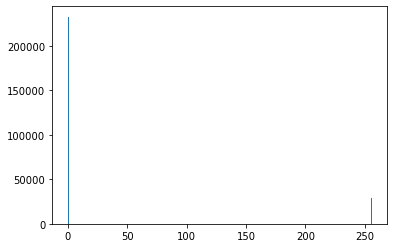

In [30]:
SIZE = 256

cv2.imshow("threshold", threshed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

hist = cv2.calcHist(images = [threshed_img], 
                    channels = [0], 
                    mask = None,
                    histSize = [SIZE],
                    ranges = [0, SIZE])

plt.hist(threshed_img.ravel(), SIZE, [0, SIZE])
plt.show()

In [31]:
height, width = threshed_img.shape[0], threshed_img.shape[1] 
rectangle_area = height * width
rate_w = hist[-1] / rectangle_area
rate_b = hist[0] / rectangle_area

ds_area = 100*100 # 전체 면적
ds_S = ds_area*rate_w # 질병 면적
st_S = ds_area*rate_b # 정상 면적
    
print("피해지역면적 : ", ds_S, "\n정상지역면적 : ", st_S)

피해지역면적 :  [1105.44581703] 
정상지역면적 :  [8894.55418297]
